We will start our exploration using the excellent blogpost 
[http://www.acgeospatial.co.uk/sentinel-5p-and-python/](http://www.acgeospatial.co.uk/sentinel-5p-and-python/) as a 
basis.

Map plotting basics taken from [Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html)

# Map basics

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [6]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

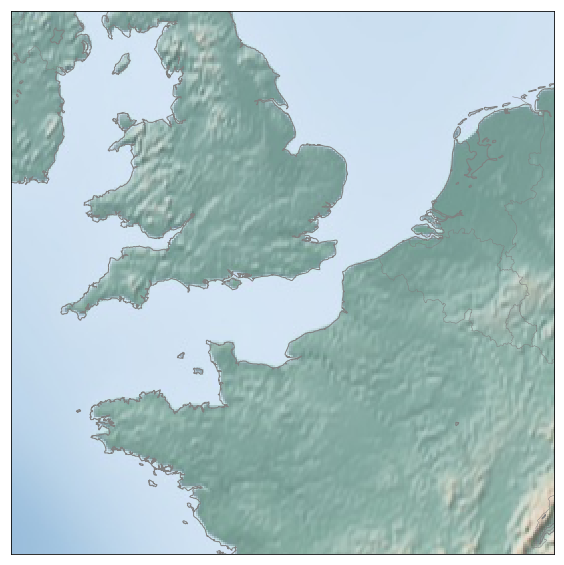

In [14]:
# 1. Draw the map background
fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=50.7, lon_0=0,
            width=1E6, height=1E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# TROPOMI/S5P Ozone Total Column
Product document can be found [here](https://sentinel.esa.int/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Ozone-Total-Column)

## Intro (taken from product document):

O3 is of crucial importance for the equilibrium of the Earth atmosphere. In the stratosphere, the ozone layer
shields the biosphere from dangerous solar ultraviolet radiation. In the troposphere, it acts as an efficient
cleansing agent, but at high concentration it also becomes harmful to human and animal health and vegetation.
Ozone is an important greenhouse-gas contributor to ongoing climate change. Since the discovery of the
Antarctic ozone hole in the mid-eighties and the subsequent Montreal protocol that regulated the production of
chlorine-containing ozone-depleting substances, ozone has been routinely monitored from the ground and
from space.


In [15]:
from netCDF4 import Dataset
import numpy as np

In [16]:
my_example_nc_file = './data/S5P_NRTI_L2__O3_____20180807T135217_20180807T135717_04231_01_010101_20180807T143149.nc'
fh = Dataset(my_example_nc_file, mode='r')
print (fh)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    institution: DLR-ATP
    source: Sentinel 5 precursor, TROPOMI, space-borne remote sensing, L2
    history: 2018-08-07 14:28:54.836928 f_s5pops upas-l2 JobOrder.561570003.xml 
    summary: TROPOMI/S5P L2 data Swath 7x3.5km2 processed in NRTI mode
    tracking_id: 08718436-eba1-4698-8d1e-af878b6f6c79
    id: S5P_NRTI_L2__O3_____20180807T135217_20180807T135717_04231_01_010101_20180807T143149
    time_reference: 2018-08-07T00:00:00
    time_reference_days_since_1950: 25055
    time_reference_julian_day: 2458337.5
    time_reference_seconds_since_1970: 1533600000
    time_coverage_start: 2018-08-07T13:52:12
    time_coverage_end: 2018-08-07T13:57:24
    time_coverage_duration: PT312.000S
    time_coverage_resolution: PT1.080S
    orbit: 4231
    references: TBD
    processor_version: 01.01.01
    keywords_vocabulary: AGU index terms, http://publications.agu.org/author-resource-

By printing the fh.groups we can find the groups in the data, which are called ‘PRODUCT’ and ‘METADATA’. By printing fh.groups[‘PRODUCT’] we find the product has data about the dimension and variables.

In [17]:
print (fh.groups)

print (fh.groups['PRODUCT'])

OrderedDict([('PRODUCT', <class 'netCDF4._netCDF4.Group'>
group /PRODUCT:
    dimensions(sizes): scanline(279), ground_pixel(450), time(1), corner(4), layer(13), level(14)
    variables(dimensions): int32 scanline(scanline), int32 ground_pixel(ground_pixel), int32 time(time), int32 corner(corner), float32 latitude(time,scanline,ground_pixel), float32 longitude(time,scanline,ground_pixel), int32 delta_time(time,scanline,ground_pixel), <class 'str'> time_utc(time,scanline), uint8 qa_value(time,scanline,ground_pixel), float32 ozone_total_vertical_column(time,scanline,ground_pixel), float32 ozone_total_vertical_column_precision(time,scanline,ground_pixel), int32 layer(layer), int32 level(level)
    groups: SUPPORT_DATA
), ('METADATA', <class 'netCDF4._netCDF4.Group'>
group /METADATA:
    dimensions(sizes): 
    variables(dimensions): 
    groups: EOP_METADATA, ISO_METADATA, QA_STATISTICS, GRANULE_DESCRIPTION, ESA_METADATA
)])
<class 'netCDF4._netCDF4.Group'>
group /PRODUCT:
    dimensions(

In [18]:
print (fh.groups['PRODUCT'].variables.keys())


odict_keys(['scanline', 'ground_pixel', 'time', 'corner', 'latitude', 'longitude', 'delta_time', 'time_utc', 'qa_value', 'ozone_total_vertical_column', 'ozone_total_vertical_column_precision', 'layer', 'level'])


In [60]:
fh.groups['PRODUCT'].variables['time']

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    _FillValue: -2147483647
    units: seconds since 2010-01-01 00:00:00
    standard_name: time
    axis: T
    long_name: reference time for the measurements
    comment: The time in this variable corresponds to the time in the time_reference global attribute
path = /PRODUCT
unlimited dimensions: 
current shape = (1,)
filling on

In [25]:
lons = fh.groups['PRODUCT'].variables['longitude'][:][0,:,:]
lats = fh.groups['PRODUCT'].variables['latitude'][:][0,:,:]
o3 = fh.groups['PRODUCT'].variables['ozone_total_vertical_column'][0,:,:]
print (lons.shape)
print (lats.shape)
print (o3.shape)


o3_units = fh.groups['PRODUCT'].variables['ozone_total_vertical_column'].units

(279, 450)
(279, 450)
(279, 450)


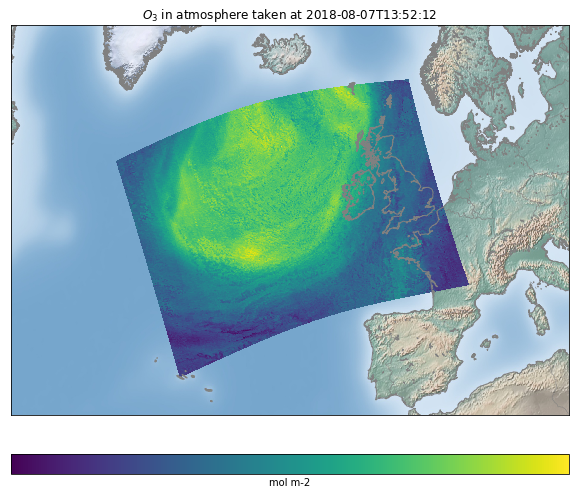

In [85]:
from matplotlib.colors import LogNorm
lon_0 = lons.mean()
lat_0 = lats.mean()

# 1. Draw the map background
fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=lat_0, lon_0=lon_0,
            width=5000000,height=3500000)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

xi, yi = m(lons, lats)
# Plot Data
cs = m.pcolor(xi,yi,np.squeeze(o3),norm=LogNorm(), cmap='viridis')
# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(o3_units)

# Add Title
plt.title(r'$O_3$ in atmosphere taken at '+fh.groups['METADATA'].groups['GRANULE_DESCRIPTION'].GranuleStart)
plt.show()

# TROPOMI L2 Nitrogendioxide
### 3.1 Recommendations for data usage taken from [README](https://sentinel.esa.int/documents/247904/3541451/Sentinel-5P-Nitrogen-Dioxide-Level-2-Product-Readme-File)
The quality of the individual observations depends on many factors, including cloud cover, albedo,
presence of snow-ice, saturation, geometry etc. These aspects are taken into account in the definition
of the qa_value, available for each individual observation, which provides the users of the data with an
easy filter to remove less accurate observations. The "quality assurance value" (qa_value) is a
continuous variable, ranging from 0 (error) to 1 (all is well). This is the main flag for data usage:
* qa_value		>		0.75

This is the recommended pixel filter. This removes clouds (cloud radiance fraction > 0.5),
scenes covered by snow/ice, errors and problematic retrievals.
* qa_value		>		0.50

Compared to above, this adds the good quality retrievals over clouds and over scenes
covered by snow/ice. Errors and problematic retrievals are still filtered out. In particular this
may be useful for assimilation and model comparison studies.

In [94]:
my_example_nc_file = './data/NO2/S5P_NRTI_L2__NO2____20180807T135217_20180807T135717_04231_01_010100_20180807T143150.nc'
fh = Dataset(my_example_nc_file, mode='r')

In [102]:
lons = fh.groups['PRODUCT'].variables['longitude'][:][0,:,:]
lats = fh.groups['PRODUCT'].variables['latitude'][:][0,:,:]
no2 = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'][0,:,:]
print (lons.shape)
print (lats.shape)
print (o3.shape)

no2[fh.groups['PRODUCT'].variables['qa_value'][0,:,:]<0.75]=np.nan
no2_units = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'].units

(290, 450)
(290, 450)
(290, 450)


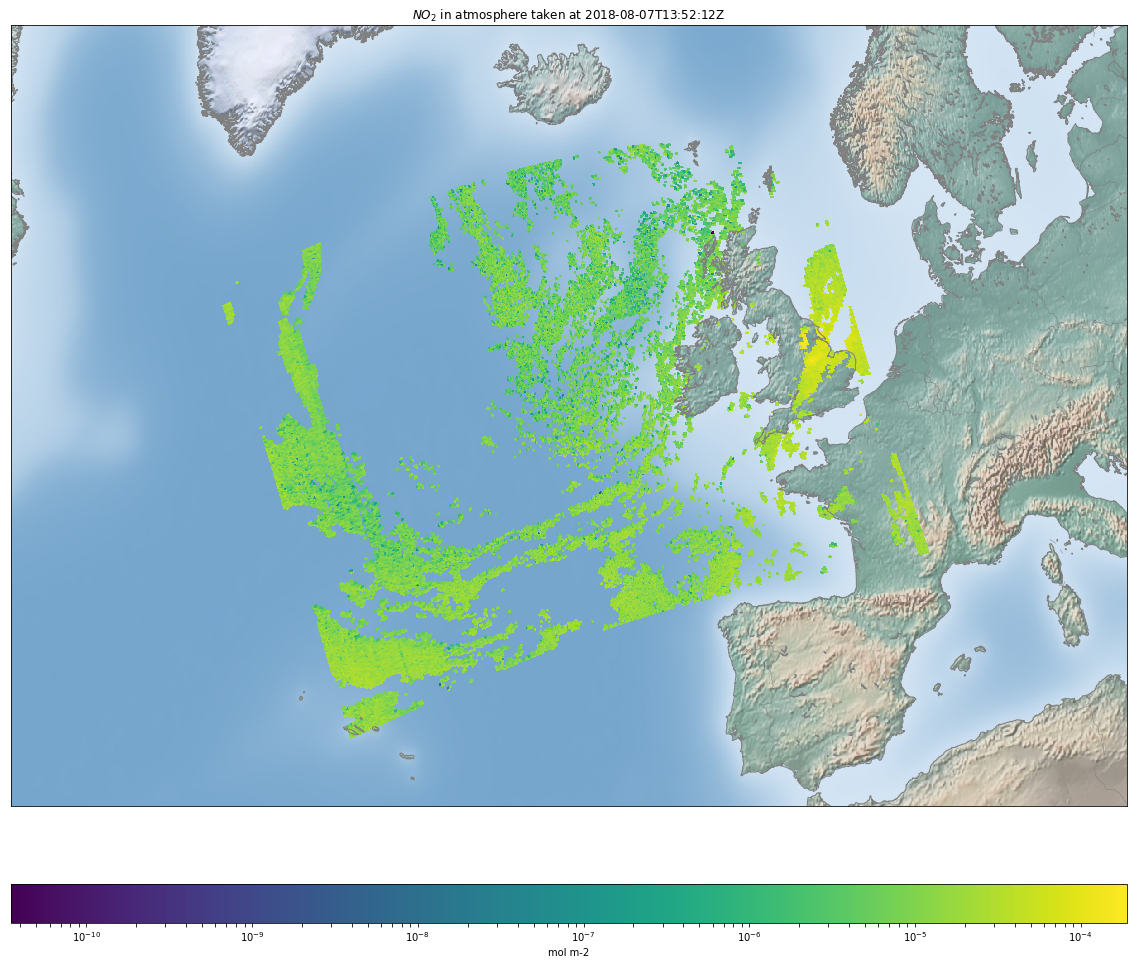

In [103]:
from matplotlib.colors import LogNorm
lon_0 = lons.mean()
lat_0 = lats.mean()

# 1. Draw the map background
fig = plt.figure(figsize=(20, 20))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=lat_0, lon_0=lon_0,
            width=5000000,height=3500000)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

xi, yi = m(lons, lats)
# Plot Data
cs = m.pcolor(xi,yi,np.squeeze(no2),norm=LogNorm(), cmap='viridis')
# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title(r'$NO_2$ in atmosphere taken at '+fh.groups['METADATA'].groups['GRANULE_DESCRIPTION'].GranuleStart)
plt.show()

### Another NO2 datafile

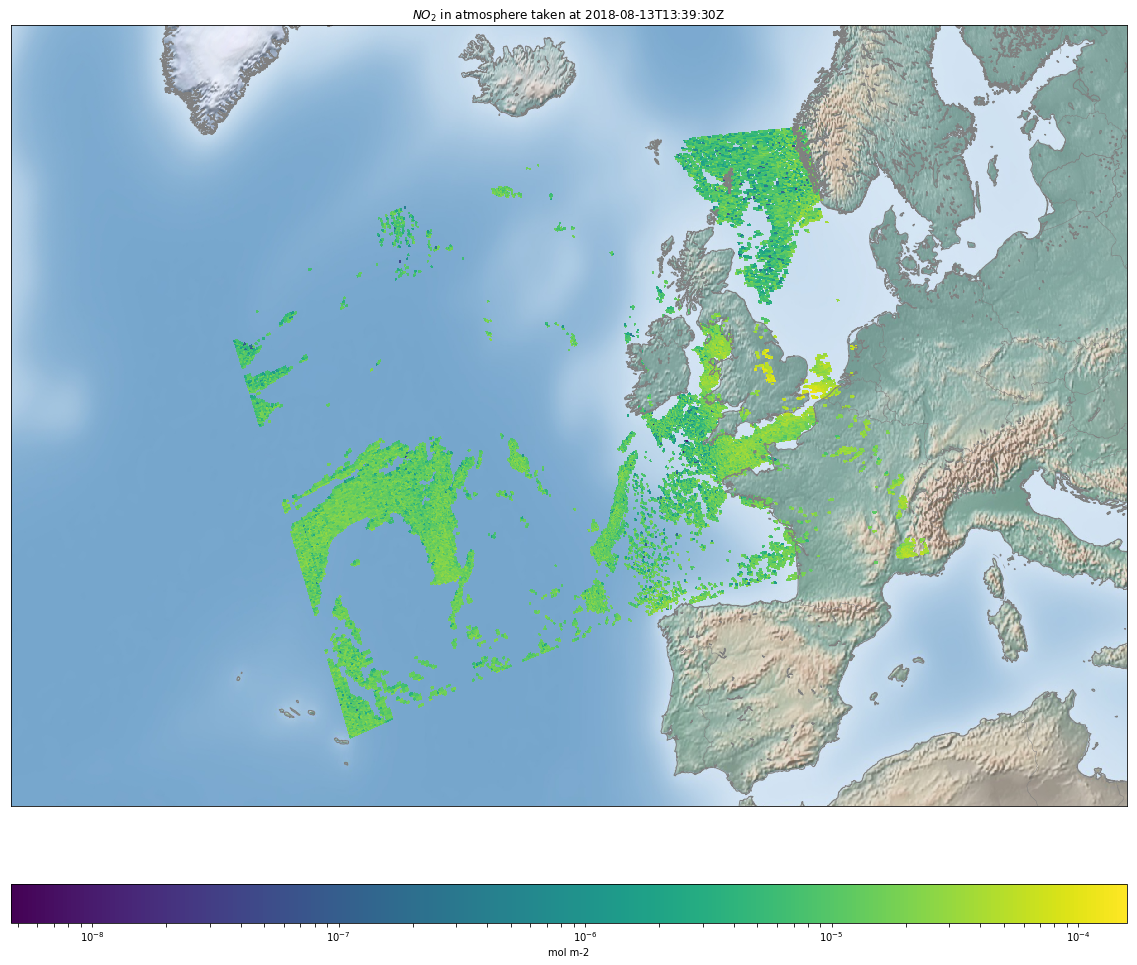

In [105]:
my_example_nc_file = './data/NO2/S5P_NRTI_L2__NO2____20180813T133935_20180813T134435_04316_01_010100_20180813T142038.nc'
fh = Dataset(my_example_nc_file, mode='r')
lons = fh.groups['PRODUCT'].variables['longitude'][:][0,:,:]
lats = fh.groups['PRODUCT'].variables['latitude'][:][0,:,:]
no2 = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'][0,:,:]


no2[fh.groups['PRODUCT'].variables['qa_value'][0,:,:]<0.75]=np.nan
no2_units = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'].units
from matplotlib.colors import LogNorm
lon_0 = lons.mean()
lat_0 = lats.mean()

# 1. Draw the map background
fig = plt.figure(figsize=(20, 20))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=lat_0, lon_0=lon_0,
            width=5000000,height=3500000)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

xi, yi = m(lons, lats)
# Plot Data
cs = m.pcolor(xi,yi,np.squeeze(no2),norm=LogNorm(), cmap='viridis')
# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title(r'$NO_2$ in atmosphere taken at '+fh.groups['METADATA'].groups['GRANULE_DESCRIPTION'].GranuleStart)
plt.show()